In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

Using TensorFlow backend.


## RNA Bind-n-Seq
RNA Bind-n-Seq dataset (RBNS) is designed to dissect the sequence and RNA structural
preferences of RBPs. An
RBP is incubated with a pool of randomized RNAs at several
different protein concentrations, typically ranging from low nanomolar to low micromolar. 

The RNA pool typically
consists of random RNAs of length 40 nt flanked by short
primers used to add the adapters needed for deep sequencing.

RBPbound RNA is reverse-transcribed into cDNA, and barcoded
sequencing adapters are added by PCR to produce libraries
for deep sequencing. Libraries corresponding to the input RNA
pool and to five or more RBP concentrations (including zero
RBP concentration as an additional control) are sequenced in
a single Illumina HiSeq 2000 lane, typically yielding at least 15–
20 million reads per library.

Most RBPs bind single-stranded RNA sequence motifs 3–8 nt
in length. 

In [3]:
def get_files_list(rbp_ind):
    
    lst = []
    for file in os.listdir(PATH):
        if file.startswith('RBP' + str(rbp_ind) + '_'):
            
            consentration = file.split('_')[1].split('nM')[0]
            consentration_val = 0
            if consentration != 'input.seq':
                consentration_val = int(consentration)
                
            lst.append((file, consentration_val))
            
    lst.sort(key=lambda x: x[1])
    print(lst)
    return [file for file,cons in lst]


def read_file_rbns(path):
    sequences = []
    with open(path, 'r') as f:
        for line in f:
            sequences.append(line.strip().split())
    return sequences

Exploring the dataset

In [5]:
PATH = 'RBNS_example/'
rbp_ind = 1

l = get_files_list(rbp_ind)

rnas_sets = []

for file in l:
    seqs = read_file_rbns(PATH + file)
    rnas_set = set([seq for (seq, count) in seqs])
    rnas_sets.append(rnas_set)

[('RBP1_input.seq', 0), ('RBP1_5nM.seq', 5), ('RBP1_20nM.seq', 20), ('RBP1_80nM.seq', 80), ('RBP1_320nM.seq', 320), ('RBP1_1300nM.seq', 1300)]


In [6]:
for i, rna_set in enumerate(rnas_sets):
    print(l[i], '\t', len(rna_set))

RBP1_input.seq 	 1000
RBP1_5nM.seq 	 1000
RBP1_20nM.seq 	 1000
RBP1_80nM.seq 	 1000
RBP1_320nM.seq 	 1000
RBP1_1300nM.seq 	 1000


In [7]:
len(rnas_sets[0].intersection(*rnas_sets[1:3]))

0

Intersection of sequences between different consentrations

In [8]:
for i in range(len(rnas_sets)-1):
    set1 = rnas_sets[i]
    for j in range(i+1, len(rnas_sets)):
        set2 = rnas_sets[j]
        print('i={}, j={}, intersection={}'.format(i, j, len(set1.intersection(set2))))

i=0, j=1, intersection=0
i=0, j=2, intersection=0
i=0, j=3, intersection=0
i=0, j=4, intersection=0
i=0, j=5, intersection=0
i=1, j=2, intersection=2
i=1, j=3, intersection=0
i=1, j=4, intersection=0
i=1, j=5, intersection=0
i=2, j=3, intersection=1
i=2, j=4, intersection=0
i=2, j=5, intersection=0
i=3, j=4, intersection=0
i=3, j=5, intersection=1
i=4, j=5, intersection=0


In [9]:
kernel_size = 12
max_size = 45

reverse_compliment_base = {'A': 'U', 'C': 'G', 'T': 'A', 'G': 'C', 'N': 'N'}
#reverse_compliment_base = {'A': 'A', 'C': 'C', 'T': 'U', 'G': 'G', 'N': 'N'}

def reverse_compliment(string):
    string = [reverse_compliment_base[base] for base in string[::-1]]
    #string = [reverse_compliment_base[base] for base in string]
    
    return ''.join(string)

def pad(string, max_size):
    string += 'N' * (max_size-len(string))
    return string

def pad_conv(string, kernel_size):
    pad = 'N'*(kernel_size-1)
    string = pad + string + pad
    return string

def read_file_rncmpt(file_path):
    sequences = []
    with open(file_path) as f:
        for line in f:
            sequences.append(line.strip())
    return sequences


def one_hot(string):

    dict = {'A': np.array([1, 0, 0, 0]), 'G': np.array([0, 1, 0, 0]),
            'C': np.array([0, 0, 1, 0]), 'U': np.array([0, 0, 0, 1]),
            'N': np.array([0.25]*4)}
    
    vec_list = [dict[c].reshape(1, -1) for c in string]
    
    return np.concatenate(vec_list, axis=0).reshape(len(string), 4, 1)


def get_x(str_dict):
    x = [entry['x'] for entry in str_dict]
    return x


def get_str_dict(seqs_lists):
    str_dict = {}
    for lst_ind, seqs in enumerate(seqs_lists):
        for seq, count in seqs:
            if seq in str_dict:
                str_dict[seq]['y'][lst_ind] = 1
            else:
                str_dict[seq] = {'x': one_hot(pad_conv(pad(seq, max_size), kernel_size)), 
                                 'y': [1 if i == lst_ind else 0 for i in range(len(seqs_lists))]}
    return list(str_dict.values())


def get_y(str_dict):
    y = [entry['y'] for entry in str_dict]
    return y

In [10]:
seqs_lists = []

for file in l:
    seqs = read_file_rbns(PATH + file)
    rc_seqs = [(reverse_compliment(seq), count) for (seq, count) in seqs]
    seqs_lists.append(rc_seqs)

str_dict = get_str_dict(seqs_lists)
x_train = get_x(str_dict)
y_train = get_y(str_dict)

In [11]:
x_train[0].shape

(67, 4, 1)

In [12]:
x_train[0]

array([[[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.  ],
        [0.  ],
        [1.  ],
        [0.  ]],

       [[1.  ],
        [0.  ],
        [0.  ],
        [0.  ]],

       [[0.  ],
        [1.  ],
        [0.  ],
        [0.  ]],

       [[0.  ],
        [0.  ],
        [0.  ],
        [1.  ]],

       [[0

In [35]:
y_train[0]

[1, 0, 0, 0, 0, 0]

In [36]:
len(x_train)

5996

In [16]:
num_classes = 6

model = Sequential()

model.add(Conv2D(32, (12, 4), strides=(1, 1), padding='same', input_shape=x_train[0].shape))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(6, 4)))

model.add(Flatten())
model.add(Dense(64))

model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 67, 4, 32)         1568      
_________________________________________________________________
activation_1 (Activation)    (None, 67, 4, 32)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 1, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 352)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                22592     
_________________________________________________________________
activation_2 (Activat

In [17]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [18]:
model.fit(np.array(x_train), np.array(y_train),
              batch_size=batch_size,
              epochs=40,
              shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
5996/5996 [==============================] - 1s 240us/step - loss: 1.7948 - acc: 0.1698
Epoch 2/40
5996/5996 [==============================] - 1s 191us/step - loss: 1.7929 - acc: 0.1753
Epoch 3/40
5996/5996 [==============================] - 1s 191us/step - loss: 1.7914 - acc: 0.1821
Epoch 4/40
5996/5996 [==============================] - 1s 197us/step - loss: 1.7893 - acc: 0.1876
Epoch 5/40
5996/5996 [==============================] - 1s 195us/step - loss: 1.7871 - acc: 0.1991
Epoch 6/40
5996/5996 [==============================] - 1s 196us/step - loss: 1.7838 - acc: 0.2078
Epoch 7/40
5996/5996 [==============================] - 1s 190us/step - loss: 1.7813 - acc: 0.2173
Epoch 8/40
5996/5996 [==============================] - 1s 186us/step - loss: 1.7776 - acc: 0.2253
Epoch 9/40
5996/5996 [==============================] - 1s 189us/step - loss: 1.7741 - acc: 0.2315
Epoch 10/40
5996/5996 [==============================] - 1s 1

In [19]:
file_path = 'RNCMPT/RBP1_RNCMPT.sorted'
seqs = read_file_rncmpt(file_path)
seqs = [pad_conv(pad(seq, max_size), kernel_size) for seq in seqs]

x_test = np.array([one_hot(seq) for seq in seqs])
y_test = [int(x) for x in np.append(np.ones(1000), np.zeros(len(x_test)-1000), axis=0)]

x_test.shape

(240036, 67, 4, 1)

In [22]:
y_pred = model.predict(x_test)

In [23]:
len(y_pred)

240036

In [24]:
y_pred[0]

array([0.16157469, 0.0362629 , 0.12163743, 0.0790666 , 0.01738063,
       0.00923195], dtype=float32)

In [25]:
y_pred_scores = [np.dot(y, np.array([1, 1, 1, 1, 1, 1])) for y in y_pred]

In [27]:
y_pred_scores[0]

0.4251542091369629

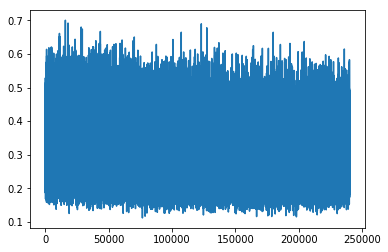

In [28]:
plt.plot(range(len(y_pred_scores)), y_pred_scores)

In [29]:
x_test_y_pred = list(zip(seqs, y_pred_scores, list(range(len(seqs)))))

In [30]:
x_test_y_pred_sorted = sorted(x_test_y_pred, key=lambda x: x[1], reverse=True)

x_test_y_pred_tagged = [(seq, tag, ind) for (seq, score, ind),tag in zip(x_test_y_pred_sorted, y_test)]

In [31]:
x_test_y_pred_tagged = sorted(x_test_y_pred_tagged, key=lambda x: x[2])

In [32]:
positives = sum([tag for (seq, tag, ind) in x_test_y_pred_tagged[:1000]])
print('positives', positives)

positives 2


In [33]:
from sklearn.metrics import average_precision_score

avg_precision = average_precision_score(y_test, [tag for (seq, tag, ind) in x_test_y_pred_tagged])
print('avg_precision', avg_precision)

avg_precision 0.0041617096768818


In [34]:
import random as rand

def ran_avg_precision():
    random_pred = [int(x) for x in np.append(np.ones(1000), np.zeros(len(x_test)-1000), axis=0)]
    rand.shuffle(random_pred)
    print([sum(rand.sample(random_pred, len(random_pred))[:1000]) for i in range(100)])
    average_precision_score(y_test, random_pred)